In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay     
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [17]:

df = pd.read_csv("Students.csv")

print("=== HEAD ===")
print(df.head(8))

=== HEAD ===
  student_id           name  gender  age section  math  english  science  \
0      S0001  Sakib Hossain  Female   17       B    73       59       78   
1      S0002  Taslima Karim  Female   22       A    60       93       80   
2      S0003  Lubna Sultana    Male   15       B    56       52       71   
3      S0004   Fatima Haque  Female   22       B    54       41       72   
4      S0005  Sadia Sultana    Male   18       A    91       57       68   
5      S0006  Nadia Sultana    Male   16       B    66       38       73   
6      S0007     Rana Karim    Male   15       C    54       99       66   
7      S0008     Shuvo Nath    Male   14       D    43       66       33   

   social_science  attendance_percent  average_score grade passed  
0              93                86.1          75.75     A    Yes  
1              49                92.3          70.50     A    Yes  
2              17                74.2          49.00     C    Yes  
3              40             

In [15]:
print("\n=== SHAPE ===")
print(df.shape)



=== SHAPE ===
(1000, 13)


In [4]:
print("\n=== INFO ===")
print(df.info())


=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          1000 non-null   object 
 1   name                1000 non-null   object 
 2   gender              1000 non-null   object 
 3   age                 1000 non-null   int64  
 4   section             1000 non-null   object 
 5   math                1000 non-null   int64  
 6   english             1000 non-null   int64  
 7   science             1000 non-null   int64  
 8   social_science      1000 non-null   int64  
 9   attendance_percent  1000 non-null   float64
 10  average_score       1000 non-null   float64
 11  grade               1000 non-null   object 
 12  passed              1000 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB
None


In [5]:
print("\n=== MISSING VALUES (per column) ===")
print(df.isnull().sum())


=== MISSING VALUES (per column) ===
student_id            0
name                  0
gender                0
age                   0
section               0
math                  0
english               0
science               0
social_science        0
attendance_percent    0
average_score         0
grade                 0
passed                0
dtype: int64


In [18]:
preferred_targets = ['target', 'passed', 'pass', 'label', 'y']
target_col = None
lower_cols = [c.lower() for c in df.columns]

for name in preferred_targets:
    if name in lower_cols:
        target_col = df.columns[lower_cols.index(name)]
        break

In [7]:
if target_col is None:
    # fallback: choose last column as target (common in many datasets)
    target_col = df.columns[-1]

print(f"\nDetected target column: '{target_col}'")



Detected target column: 'passed'


In [8]:
# Show target distribution
print("\nTarget value counts:")
print(df[target_col].value_counts(dropna=False))


Target value counts:
passed
Yes    991
No       9
Name: count, dtype: int64


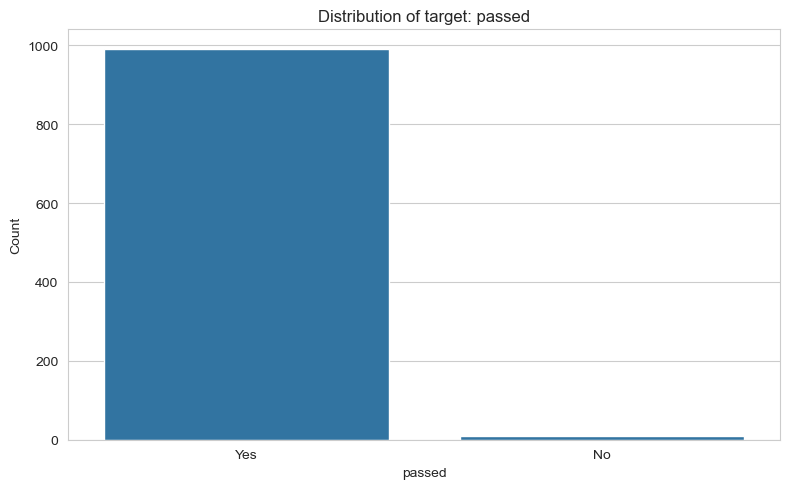

In [9]:
# Ensure plots render (if running in notebook)
plt.figure(figsize=(8,5))
sns.countplot(data=df, x=target_col, order=df[target_col].value_counts().index)
plt.title(f"Distribution of target: {target_col}")
plt.xlabel(target_col)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [20]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
# remove target from features lists if present
if target_col in numeric_cols: numeric_cols.remove(target_col)
if target_col in categorical_cols: categorical_cols.remove(target_col)



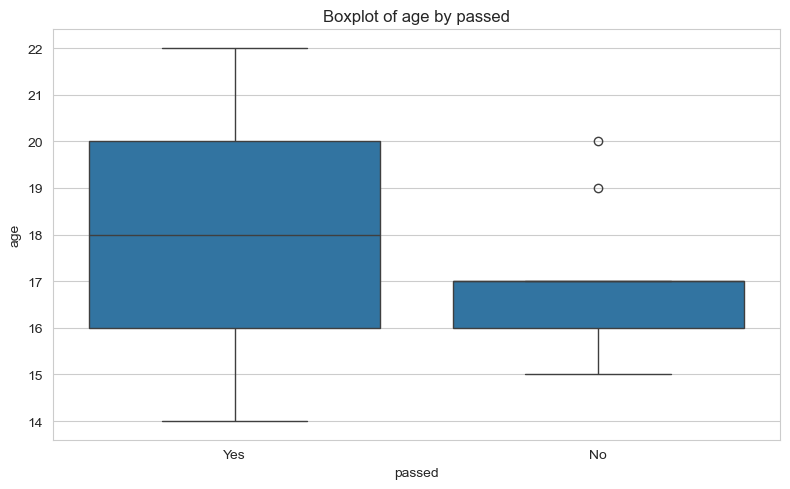

In [21]:
if len(numeric_cols) >= 1:
    feat = numeric_cols[0]
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x=target_col, y=feat)
    plt.title(f"Boxplot of {feat} by {target_col}")
    plt.tight_layout()
    plt.show()

<Figure size 1000x600 with 0 Axes>

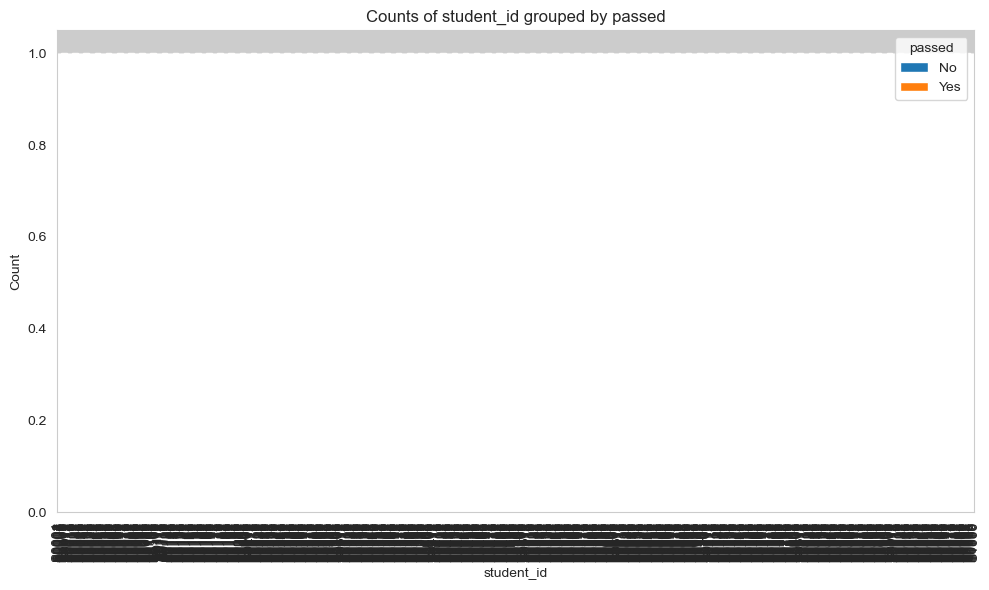

In [22]:
if len(categorical_cols) >= 1:
    cat = categorical_cols[0]
    plt.figure(figsize=(10,6))
    # prepare counts
    ct = pd.crosstab(df[cat].fillna("Missing"), df[target_col])
    ct_norm = ct.div(ct.sum(axis=1), axis=0)  # normalized (optional)
    ct.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f"Counts of {cat} grouped by {target_col}")
    plt.xlabel(cat)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns found for barplot demonstration.")

In [24]:
# Separate X and y
X = df.drop(columns=[target_col])
y = df[target_col].copy()

# If y is object (strings), encode later with LabelEncoder (but keep original for reporting)
le = LabelEncoder()
y_encoded = None
if y.dtype == 'object' or y.dtype.name == 'category' or y.dtype == bool:
    try:
        y_encoded = le.fit_transform(y.astype(str))
        print("\nLabelEncoder classes:", le.classes_)
    except Exception as e:
        print("Label encoding failed:", e)
        y_encoded = y.copy()  # fallback
else:
    y_encoded = y.values



LabelEncoder classes: ['No' 'Yes']


In [25]:

# Identify numeric and categorical columns again from X
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['age', 'math', 'english', 'science', 'social_science', 'attendance_percent', 'average_score']
Categorical columns: ['student_id', 'name', 'gender', 'section', 'grade']


In [26]:

# Build preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [28]:

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'  # drop any other columns not specified
)

In [29]:
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train target distribution (encoded):\n{pd.Series(y_train).value_counts()}")
print(f"Test target distribution (encoded):\n{pd.Series(y_test).value_counts()}")


Train shape: (800, 12), Test shape: (200, 12)
Train target distribution (encoded):
1    793
0      7
Name: count, dtype: int64
Test target distribution (encoded):
1    198
0      2
Name: count, dtype: int64


In [32]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

print("\nFitting the model...")
clf.fit(X_train, y_train)
print("Model training completed.")

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on test set: {acc:.4f}\n")



Fitting the model...
Model training completed.

Accuracy on test set: 0.9900



In [33]:
print("Classification Report:")
if isinstance(y_encoded[0], (np.integer, np.floating)):
    # numeric labels: just print report
    print(classification_report(y_test, y_pred))
else:
    # if label encoded and we have classes, map names
    if 'le' in globals() and hasattr(le, 'classes_'):
        target_names = [str(c) for c in le.classes_]
        print(classification_report(y_test, y_pred, target_names=target_names))
    else:
        print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      0.99       198

    accuracy                           0.99       200
   macro avg       0.49      0.50      0.50       200
weighted avg       0.98      0.99      0.99       200



<Figure size 600x500 with 0 Axes>

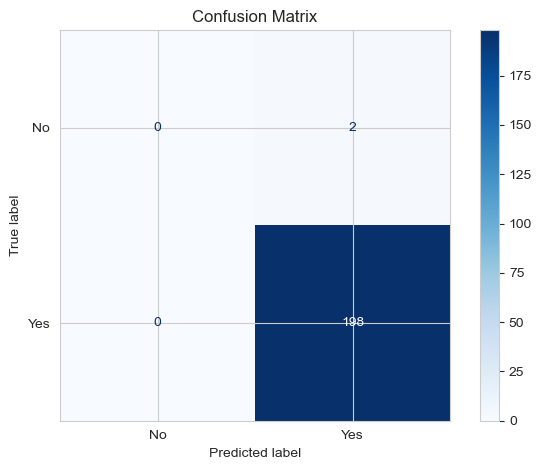

In [36]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=(le.classes_ if (hasattr(le, 'classes_')) else None))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# else:
#     print("No categorical columns found for barplot demonstration.")


In [40]:

out_path = "/mnt/data/predictions.csv"
results.to_csv(out_path, index=False)
print(f"\nSaved test predictions to: {out_path}")


Saved test predictions to: /mnt/data/predictions.csv
